<a href="https://colab.research.google.com/github/abhionair1/Autoencoder/blob/main/redone_U3W13_49_Autoencoder_Word2vec_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

At the end of the experiment, you will be able to :

* understand how to deal with the text preprocessing
* create effective semantic representations of variable sized text



#### Description

This dataset is a collection of approximately 20,000 newsgroup documents, partitioned nearly evenly across 20 different newsgroups. That is there are approximately one thousand documents taken from each of the following newsgroups:

    alt.athesim
    comp.graphics   
    comp.os.ms-windows.misc
    comp.sys.ibm.pc.hardware
    comp.sys.mac.hardware
    comp.windows.x
    misc.forsale
    rec.autos
    rec.motorcycles
    rec.sport.baseball
    rec.sport.hockey
    sci.crypt
    sci.electronics
    sci.med
    sci.space
    soc.religion.christian
    talk.politics.guns
    talk.politics.mideast
    talk.politics.misc
    talk.religion.misc

The dataset consists **Usenet** posts--essentially an email sent by someone to that newsgroup. They typically contain quotes from previous posts as well as cross posts; that is a few posts that may be sent to more than one newsgroup.

Each newsgroup is stored in a subdirectory, with each post stored as a separate file.

Data source to this experiment: http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups

### AI/ML Technique

#### Autoencoder

An autoencoder is a feedforward, non-recurrent neural network which is similar to a multilayer perceptron (MLP) – having an input layer, an output layer and one or more hidden layers connecting them. However, in an autoencoder, the output layer has the same number of nodes as the input layer and reconstructs its own inputs (instead of predicting the target value Y given inputs X).


An autoencoder is made up of two components- the encoder and the decoder network. The task of the encoder is to generate a lower-dimensional embedding Z, which is referred to as latent vector, or latent representation. After that, we have the decoder stage in which Z is reconstructed to X' prime, which is the same as X (input).


![alt text](https://cdn.talentsprint.com/aiml/Experiment_related_data/IMAGES/6.png)


In [5]:
!pip install kaggle
from google.colab import drive
drive.mount('/content/drive')
!mkdir ~/.kaggle
!cp /content/drive/MyDrive/Kaggle_api/kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [8]:
!kaggle datasets download -d umbertogriffo/googles-trained-word2vec-model-in-python

 99% 3.16G/3.17G [00:34<00:00, 162MB/s]
100% 3.17G/3.17G [00:34<00:00, 99.5MB/s]


In [9]:
!unzip googles-trained-word2vec-model-in-python.zip

Archive:  googles-trained-word2vec-model-in-python.zip
  inflating: GoogleNews-vectors-negative300.bin  
  inflating: GoogleNews-vectors-negative300.bin.gz  


In [13]:
!unzip "/content/drive/MyDrive/AIML Stuff/Datasets/AIML_DS_NEWSGROUPS_PICKELFILE.pkl.zip"

Archive:  /content/drive/MyDrive/AIML Stuff/Datasets/AIML_DS_NEWSGROUPS_PICKELFILE.pkl.zip
  inflating: AIML_DS_NEWSGROUPS_PICKELFILE.pkl  


In [14]:
import pickle
dataset = pickle.load(open("AIML_DS_NEWSGROUPS_PICKELFILE.pkl",'rb'))
print(dataset.keys())

dict_keys(['talk.politics.mideast', 'rec.autos', 'comp.sys.mac.hardware', 'alt.atheism', 'rec.sport.baseball', 'comp.os.ms-windows.misc', 'rec.sport.hockey', 'sci.crypt', 'sci.med', 'talk.politics.misc', 'rec.motorcycles', 'comp.windows.x', 'comp.graphics', 'comp.sys.ibm.pc.hardware', 'sci.electronics', 'talk.politics.guns', 'sci.space', 'soc.religion.christian', 'misc.forsale', 'talk.religion.misc'])


In [15]:
# Importing pytorch packages
import torch
from torch import nn
import torch.optim as optim

import torchvision
from torchvision import datasets, transforms

import numpy as np
import gensim

# Matplotlib is used for ploting graphs
import matplotlib.pyplot as plt

### Dividing the dataset into train and test

We will use 950 samples from each class in the training set, and the remaining 50 (Are you sure?)  in the test set.

In [16]:
train_set = {}
test_set = {}

# Clean dataset for text encoding issues :- Very useful when dealing with non-unicode characters
for key in dataset:
    dataset[key] = [[i.decode('utf-8', errors='replace').lower() for i in f] for f in dataset[key]]

# Break dataset into 95-5 split for training and testing
n_train = 0
n_test = 0
for k in dataset:
    split = int(0.95*len(dataset[k]))
    train_set[k] = dataset[k][0:split]
    test_set[k] = dataset[k][split:-1]
    n_train += len(train_set[k])
    n_test += len(test_set[k])

### Calculating the frequency of the words

As you might have realized, machine learning algorithms need good feature representations of different inputs. Concretely, we would like to represent each news article 𝐷 in terms of a feature vector 𝑉, which can be used for classification. Feature vector 𝑉 is made up of the number of occurrences of each word in the vocabulary. Let us count the number of occurrences of every word in the news documents in the training set.

In [17]:
import collections
import re
import operator
frequency = collections.defaultdict(int)

for key in train_set:
    for f in train_set[key]:

        # Find all words which consist only of capital and lowercase characters and are between length of 2-9.
        # We ignore all special characters such as !.$ and words containing numbers
        words = re.findall(r'(\b[A-Za-z][a-z]{2,9}\b)', ' '.join(f))

        for word in words:
            frequency[word] += 1

sorted_words = sorted(frequency.items(), key=operator.itemgetter(1), reverse=True)

### Preprocessing the data

Now we got some rough ideas about kind of words that appear frequently, and those that occur rarely, and we can observe that different words appear with different frequencies. The most common words appear in almost all documents. Hence, for a classification task, having information about those words' frequencies does not matter much since they appear frequently in every type of document. To get a good feature representation, we eliminate them since they do not add too much value. Additionally, notice how the least frequent words appear so rarely that they might not be useful either.

Let us pre-process our news articles now to remove the most frequent and least frequent words by thresholding their counts:

In [18]:
valid_words = collections.defaultdict(int)

print('Number of words before preprocessing:', len(sorted_words))

# Ignore the 25 most frequent words, and the words which appear less than 100 times
ignore_most_frequent = 25
freq_thresh = 100
feature_number = 0
for word, word_frequency in sorted_words[ignore_most_frequent:]:
    if word_frequency > freq_thresh:
        valid_words[word] = feature_number
        feature_number += 1

print('Number of words after preprocessing:', len(valid_words))

word_vector_size = len(valid_words)

Number of words before preprocessing: 89599
Number of words after preprocessing: 4096


### Loading the predefined word2vec file

we aim to predict the next word given the context in which the word appears. (For example, given the last 𝑛 words, predict the next word). A very smart way to do this is by using a feature representation called "Word2Vec" with transforms each word into 300-dimensional vectors.
Link to pretrained 300 dimensional word2vec: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM&export=download


Converting each document into average of the word2vec vectors of all valid words in document.


In [20]:
model = gensim.models.KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True, limit=500000)

Function for word2vec

In [21]:
word2vec_vector_size = 300

'''
 This method converts documents to word vectors. It first checks if the word is valid according to our initial frequency
 threshold. Next, if it is, we add the precomputed word vectors together. If the word is valid, but we do not have a valid
 vector to represent the word, we add a random gaussian noise instead. Since we do not want to induce new noise each time,
 we store the same noise vector for training and test time in substitute_word_vecs variable.
'''
def convert_to_w2v(dataset, number_of_documents, substitute_word_vecs={}):
    d = {}
    labels = np.zeros((number_of_documents, 1))
    w2v_rep = np.zeros((number_of_documents, word2vec_vector_size))

    # Iterate over the dataset and split into words
    i = 0
    for label, class_name in enumerate(dataset):
        for f in dataset[class_name]:
            text = ' '.join(f).split(' ')
            valid_count = 1
            for word in text:

                # Check if word is valid or not according to original dataset pruning
                if word in valid_words:
                    try:
                        w2v_rep[i] += model[word]
                        d[word] = model[word]
                    except:
                        '''The word isn't in our pretrained word-vectors, hence we add a random gaussian noise
                         to account for this. We store the random vector we assigned to the word, and reuse
                         the same vector during test time to ensure consistency.'''

                        if word not in substitute_word_vecs.keys():
                            substitute_word_vecs[word] = np.random.normal(-0.25, 0.25, word2vec_vector_size)

                        w2v_rep[i] += substitute_word_vecs[word]

                    valid_count += 1

            # Average
            w2v_rep[i] = w2v_rep[i] / valid_count

            # Save label
            labels[i] = label

            i += 1

    return d, w2v_rep, labels, substitute_word_vecs

### Convert the train and test datasets into their word2vec representations

> Indented block

In [22]:
d_train,train_w2v_set, train_w2v_labels, substitute_word_vecs = convert_to_w2v(train_set, n_train)
d_test,test_w2v_set, test_w2v_labels,_ = convert_to_w2v(test_set, n_test, substitute_word_vecs)

In [23]:
len(d_train),train_w2v_set.shape, train_w2v_labels.shape, len(substitute_word_vecs)

(3655, (17878, 300), (17878, 1), 350)

### Defining the Model


Let us create an autoencoder architecture. Typically an autoencoder is made up of two components, the encoder network and the decoder network. Encoding network is made up of four layers where we are trying to compressing the data into 2 features which can be easily visualized in the plot.  Decoding network is made up of four layers.

The sentences in the documents as word2vec representation are fed into the encoder network, transformed into a semantic vector of fixed size, and then unfolded back into an ordered sentences in document.


In [24]:
class autoencoder(nn.Module):
    def __init__(self):
        super(autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(300,100),
            nn.ReLU(),
            nn.Linear(100,30),
            nn.ReLU(),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Linear(30,2))
        self.decoder = nn.Sequential(
            nn.Linear(2,30),
            nn.ReLU(),
            nn.Linear(30,30),
            nn.ReLU(),
            nn.Linear(30,100),
            nn.ReLU(),
            nn.Linear(100,300))

    def forward(self, x):
        y = self.encoder(x)
        z = self.decoder(y)
        return y,z

### Calling the instances of the network

In [25]:
model = autoencoder()
model

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): ReLU()
    (6): Linear(in_features=30, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=30, bias=True)
    (1): ReLU()
    (2): Linear(in_features=30, out_features=30, bias=True)
    (3): ReLU()
    (4): Linear(in_features=30, out_features=100, bias=True)
    (5): ReLU()
    (6): Linear(in_features=100, out_features=300, bias=True)
  )
)

### Defining the loss function and optimizer

In [26]:
criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001)

### Training the Model

1. Pass the data through the model.
2. Calculate the loss by comparing the reconstructed image with the original image
3. Train the model to minimize the reconstruction error which measures the diference between the original image and the consequent reconstructed image.

In [27]:
EPOCH = 10
for epoch in range(EPOCH):
    for i, (word, w2v) in enumerate(d_train.items()):
        b_x = torch.FloatTensor(np.array(w2v))     # Converting an array to a tensor

        # Passing the data to the model (Forward Pass)
        encoded, decoded = model(b_x)

        # Calculating mean square error loss between the reconstructed image and the original image
        loss = criterion(decoded, b_x)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Performing backward pass (Backpropagation)
        loss.backward()

        # optimizer.step() updates the weights accordingly
        optimizer.step()

    print("Loss:",float(loss))

Loss: 0.07029405236244202
Loss: 0.06902868300676346
Loss: 0.06805595755577087
Loss: 0.0672527477145195
Loss: 0.06658380478620529
Loss: 0.06601633131504059
Loss: 0.06553452461957932
Loss: 0.06510476768016815
Loss: 0.06471766531467438
Loss: 0.0643685832619667


We will convert training dataset first into a torch tensor, and form a differentiable Variable.

In [28]:
# Converting an array to a tensor
value = torch.Tensor(np.array(train_w2v_set))

# Passing the data to the model (Forward Pass)
encoder_values, decoder_values = model(value)

In [29]:
# Converting pytorch variable into numpy array
encode = encoder_values.data.numpy()
decode = decoder_values.data.numpy()

In [30]:
print(encode.shape, decode.shape)

(17878, 2) (17878, 300)


In [31]:
# Storing all the words in words list
words = []
for key in substitute_word_vecs:
    words.append(key)

### Visualization of encoded data

To visualize the higher dimensional data in 2D space, we can use autoencoders.

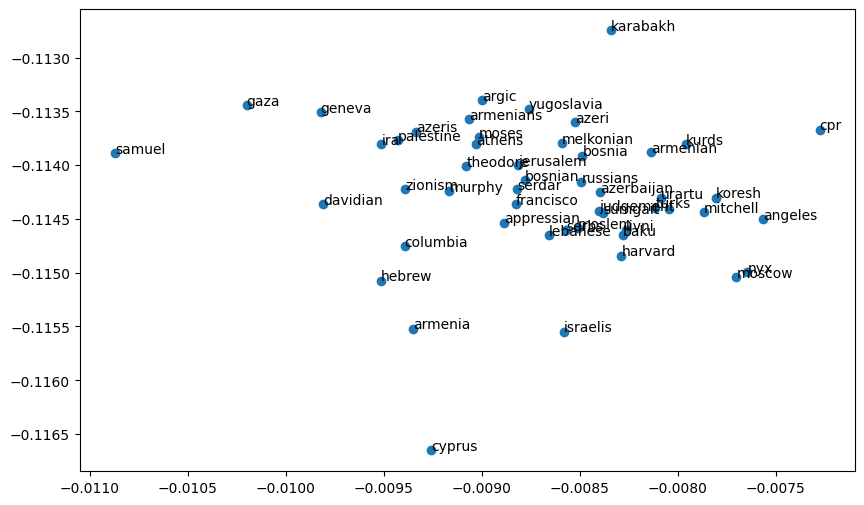

In [32]:
plt.figure(figsize=(10,6))
plt.scatter(encode[:50,0],encode[:50,1])
for i in range(len(words[:50]) - 1):
    plt.annotate(words[i], xy = (encode[i][0],encode[i][1]))
plt.show()